---

### `Hyperparameter Tuning CatBoost`

---


In this notebook, we will tune parameters of CatBoost which is another gradient boosting based technique especially for dealing with categorical variables. It has similar parameters as XGBoost:

- **`N_ESTIMATORS`** : Number of Trees. It is recommended to check that there is no obvious underfitting or overfitting before tuning any other parameters. This can be done by setting the number of iterations to a large value, using the overfitting detector parameters. But, Here we will use the same approach that we used in XGBoost Tuning. We will check performance over all the validation sets to check the overfitting.
- **`MAX_DEPTH`** : Maximum Tree Depth of the base learners.
- **`LEARNING RATE`** : This setting is used for reducing the gradient step. It affects the overall time of training: the smaller the value, the more iterations are required for training. Choose the value based on the performance expectations.
- **`L2_REG`** : We will try different values of the regularizer to find the best possible.

---


In [46]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error as msle
from datetime import timedelta

---

- We know that we have done some preprocessing on the datasets like converted categorical variable into numerical one. CatBoost handles categorical variables automatically. According to the official documentation of CatBoost https://catboost.ai/docs/concepts/parameter-tuning.html `Do not use One Hot Encoding while Preprocessing`.
- So, first of all we are going to read the original dataset.

---

### Reading the Dataset
---

In [47]:
# read the train data
train_data = pd.read_csv('train.csv')

# read the product data
product_data = pd.read_csv('product_data.csv')

# read the store data
store_data = pd.read_csv('store_data.csv')

In [48]:
# view the train data
train_data.head(2)

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS
0,14-Jan-09,367,1111009477,1.57,0,0,13
1,14-Jan-09,367,1111009497,1.39,0,0,20


- Convert the WEEK_END_DATE to datetime format.

In [49]:
train_data['WEEK_END_DATE'] = pd.to_datetime(train_data.WEEK_END_DATE)

In [50]:
# view the product data
product_data.head(2)

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ


In [51]:
# view the store data
store_data.head(2)

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707
1,389,SILVERLAKE,ERLANGER,KY,17140,MAINSTREAM,408.0,46073,24767


---

***Merge all the datasets***

In [52]:
# merge all the datasets
merged_data = train_data.merge(product_data, how= 'left', on= 'UPC')
merged_data = merged_data.merge(store_data,  how= 'left', left_on= 'STORE_NUM', right_on= 'STORE_ID')

In [53]:
# view the merged data
merged_data.head(2)

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,DESCRIPTION,MANUFACTURER,CATEGORY,...,PRODUCT_SIZE,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,2009-01-14,367,1111009477,1.57,0,0,13,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,...,15 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707
1,2009-01-14,367,1111009497,1.39,0,0,20,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,...,15 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707


In [54]:
# shape of the merged data
merged_data.shape

(232287, 21)

In [55]:
# view the data in first row
merged_data.loc[0]

WEEK_END_DATE                 2009-01-14 00:00:00
STORE_NUM                                     367
UPC                                    1111009477
BASE_PRICE                                   1.57
FEATURE                                         0
DISPLAY                                         0
UNITS                                          13
DESCRIPTION                PL MINI TWIST PRETZELS
MANUFACTURER                        PRIVATE LABEL
CATEGORY                               BAG SNACKS
SUB_CATEGORY                             PRETZELS
PRODUCT_SIZE                                15 OZ
STORE_ID                                      367
STORE_NAME                         15TH & MADISON
ADDRESS_CITY_NAME                       COVINGTON
ADDRESS_STATE_PROV_CODE                        KY
MSA_CODE                                    17140
SEG_VALUE_NAME                              VALUE
PARKING_SPACE_QTY                             196
SALES_AREA_SIZE_NUM                         24721


---

- While preprocessing, there were some missing values in `BASE_PRICE`, so we will not impute it here again and use the `final_data.csv` to get that column.
- We have done some transformations on the `PRODUCT_SIZE` also, we will use that from the updated file also.
- We have removed some features like `PARKING_SPACE_QTY` as it has high correlation with the `SALES_AREA_SIZE_NUM`.

---

In [56]:
# drop the columns
merged_data = merged_data.drop(columns= ['BASE_PRICE',
                                         'DESCRIPTION',
                                         'PRODUCT_SIZE',
                                         'STORE_ID',
                                         'PARKING_SPACE_QTY'])

In [57]:
# updated columns
merged_data.columns

Index(['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'FEATURE', 'DISPLAY', 'UNITS',
       'MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY', 'STORE_NAME',
       'ADDRESS_CITY_NAME', 'ADDRESS_STATE_PROV_CODE', 'MSA_CODE',
       'SEG_VALUE_NAME', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS'],
      dtype='object')

---

- `We have also created some more features like` :

  - ***Time Based Features***
  - ***Unique number of Manufacturers, Category and SubCategory in a Store.***
  - ***Lag Feature - Number of units sold 52 weeks before.***
  - ***Price Difference from the last week.***
  - ***Average Number of units sold in the last two months.***

- So, we will read these features form the final_data.csv that was generated after doing the feature engineering aling with the some columns like `WEEK_END_DATE`, `STORE_NUM`, `UPC`, `BASE_PRICE`, `PRODUCT_SIZE`.

---

In [58]:
# read the data with the new features.
data_with_new_features = pd.read_csv('final_data.csv',usecols=['WEEK_END_DATE',
                                                               'STORE_NUM',
                                                               'UPC',
                                                               'BASE_PRICE',
                                                               'PRODUCT_SIZE',
                                                               'year',
                                                               'month',
                                                               'day',
                                                               'day_of_year',
                                                               'week',
                                                               'quarter',
                                                               'U_MANUFACTURER',
                                                               'U_CATEGORY',
                                                               'U_SUB_CATEGORY',
                                                               'UNITS_BEFORE_52WEEK', 
                                                               'price_difference',
                                                               'AVERAGE_UNITS_IN_2_MONTH'])

In [59]:
# convert the WEEK_END_DATE to datetime
data_with_new_features.WEEK_END_DATE = pd.to_datetime(data_with_new_features.WEEK_END_DATE)

In [60]:
# let's check the shape of the merged data, and data with new features
merged_data.shape, data_with_new_features.shape

((232287, 16), (232266, 17))

---

### `Outlier Removal`

- So, you can see that there is a difference between the number of rows in both the datasets. This is because we have removed some outliers from the data while preprocessing.
- As we know that the combination of `WEEK_END_DATE`, `STORE_NUM`, `UPC` is unique for each row. So, we will do a left join and merge both the data sets on these keys.

---

In [61]:
# final data : do a left join
final_data = data_with_new_features.merge(merged_data, how = 'left', on= ['WEEK_END_DATE',
                                                                          'STORE_NUM',
                                                                          'UPC'])

In [62]:
# shape of the final data
final_data.shape

(232266, 30)

In [63]:
# view the data in the first row.
final_data.loc[0]

WEEK_END_DATE               2009-01-14 00:00:00
STORE_NUM                                   367
UPC                                  1111009477
BASE_PRICE                                 1.57
PRODUCT_SIZE                                  2
year                                       2009
month                                         1
day                                          14
day_of_year                                  14
week                                          3
quarter                                       1
U_MANUFACTURER                                4
U_CATEGORY                                    3
U_SUB_CATEGORY                                5
UNITS_BEFORE_52WEEK                           0
price_difference                              0
AVERAGE_UNITS_IN_2_MONTH                      0
FEATURE                                       0
DISPLAY                                       0
UNITS                                        13
MANUFACTURER                      PRIVAT

---


### `Validation Strategy`

- We will use the same validation stategy for the catboost and we will use 14 validation sets with training period of 2 months.


In [64]:
# create an array of unique week dates
week = final_data.WEEK_END_DATE.unique()

In [65]:
# define the function to get the validation dataframe
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        
        
    datapoints = []

    for s in model_set :
        x = {}
        train_set = data[(data.WEEK_END_DATE >= s['train_start']) & (data.WEEK_END_DATE <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape']  = data[data.WEEK_END_DATE == s['validate_week']].shape[0]
        x['test_shape'] = data[data.WEEK_END_DATE == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)

    df = pd.DataFrame.from_dict(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df    

In [66]:
# see the validation dataframe
validation_df(final_data, week, no_of_months= 2, no_of_validation= 14)

,no_days_train,set_no,test_shape,test_week,train_end,train_shape,train_start,validate_week,validation_shape
0,56 days,set1,1642,2011-09-28,2011-08-31,13089,2011-07-13,2011-09-14,1640
1,56 days,set2,1638,2011-09-21,2011-08-24,13102,2011-07-06,2011-09-07,1632
2,56 days,set3,1640,2011-09-14,2011-08-17,13101,2011-06-29,2011-08-31,1629
3,56 days,set4,1632,2011-09-07,2011-08-10,13101,2011-06-22,2011-08-24,1640
4,56 days,set5,1629,2011-08-31,2011-08-03,13109,2011-06-15,2011-08-17,1638
5,56 days,set6,1640,2011-08-24,2011-07-27,13108,2011-06-08,2011-08-10,1631
6,56 days,set7,1638,2011-08-17,2011-07-20,13108,2011-06-01,2011-08-03,1640
7,56 days,set8,1631,2011-08-10,2011-07-13,13112,2011-05-25,2011-07-27,1637
8,56 days,set9,1640,2011-08-03,2011-07-06,13104,2011-05-18,2011-07-20,1635
9,56 days,set10,1637,2011-07-27,2011-06-29,13101,2011-05-11,2011-07-13,1639


In [67]:
# define the function to get the evaluation sets from the validation dataframe

"""

get_evaluation_sets will take 2 parameters
    - df: validation dataframe
    - data: dataset
    
return:
evaluation_set = [ (train_data_1, validation_data_1), 
                   (train_data_2, validation_data_2),
                    .
                    .
                   (train_data_n, validation_data_n)]

"""

def get_evaluation_sets(df, data):
    evaluation_set = []
    
    for row in range(df.shape[0]):
        print(df.loc[row]['validate_week'])
        train_data = data[(data.WEEK_END_DATE >= df.loc[row]['train_start']) & (data.WEEK_END_DATE <= df.loc[row]['train_end'])]
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        evaluation_set.append((train_data, validation_data))
    return evaluation_set

In [68]:
# get the evaluation sets
evaluation_sets = get_evaluation_sets(validation_df(final_data,
                                                    week,
                                                    no_of_months= 2,
                                                    no_of_validation= 14),
                                      final_data)

2011-09-14 00:00:00
2011-09-07 00:00:00
2011-08-31 00:00:00
2011-08-24 00:00:00
2011-08-17 00:00:00
2011-08-10 00:00:00
2011-08-03 00:00:00
2011-07-27 00:00:00
2011-07-20 00:00:00
2011-07-13 00:00:00
2011-07-06 00:00:00
2011-06-29 00:00:00
2011-06-22 00:00:00
2011-06-15 00:00:00


In [69]:
# define the function to get the rmsle
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))

---

### `Training CatBoost Model`
- CatBoost is a little different to train as it treats categorical variables separately and we need to specify which of the features are categorical in nature.

---

In [70]:
# get the first data
train, valid = evaluation_sets[0]

In [71]:
# separate the independent and target variables from the data
train_x = train.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
train_y = train['UNITS']

valid_x = valid.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
valid_y = valid['UNITS']

In [72]:
# view the independent variables 
train_x.head(2)

,BASE_PRICE,PRODUCT_SIZE,year,month,day,day_of_year,week,quarter,U_MANUFACTURER,U_CATEGORY,...,MANUFACTURER,CATEGORY,SUB_CATEGORY,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
212625,1.52,2,2011,7,13,194,28,3,4,3,...,PRIVATE LABEL,BAG SNACKS,PRETZELS,15TH & MADISON,COVINGTON,KY,17140,VALUE,24721,12707
212626,1.53,2,2011,7,13,194,28,3,4,3,...,PRIVATE LABEL,BAG SNACKS,PRETZELS,15TH & MADISON,COVINGTON,KY,17140,VALUE,24721,12707


In [73]:
# look at the first row.
train_x.iloc[0]

BASE_PRICE                            1.52
PRODUCT_SIZE                             2
year                                  2011
month                                    7
day                                     13
day_of_year                            194
week                                    28
quarter                                  3
U_MANUFACTURER                           4
U_CATEGORY                               3
U_SUB_CATEGORY                           5
UNITS_BEFORE_52WEEK                     21
price_difference                     -0.03
AVERAGE_UNITS_IN_2_MONTH           10.6667
FEATURE                                  0
DISPLAY                                  0
MANUFACTURER                 PRIVATE LABEL
CATEGORY                        BAG SNACKS
SUB_CATEGORY                      PRETZELS
STORE_NAME                  15TH & MADISON
ADDRESS_CITY_NAME                COVINGTON
ADDRESS_STATE_PROV_CODE                 KY
MSA_CODE                             17140
SEG_VALUE_N

---

- Now, we need to identify the indices of the categorical variables in the data.
    
    - 1:  PRODUCT_SIZE has 3 categories 1, 2, 3.
    - 15: MANUFACTURER
    - 16: CATEGORY
    - 17: SUB_CATEGORY
    - 18: STORE_NAME
    - 19: ADDRESS_CITY_NAME
    - 20: ADDRESS_STATE_PROV_CODE
    - 21: MSA_CODE
    - 22: SEG_VALUE_NAME

---

In [74]:
# create a list of categorical feature indices
categorical_feature_indices = [1, 16, 17, 18, 19, 20, 21, 22, 23]

In [75]:
# create the object of the model
model_cb = CatBoostRegressor(n_estimators=2000,
                             objective='RMSE',
                             od_type='Iter',
                             eval_metric='MSLE',
                             cat_features= categorical_feature_indices,
                             random_seed=0)

In [76]:
# fit the model with the training data
model_cb.fit(train_x, train_y, eval_set=[(valid_x,valid_y)])

0:	learn: 6.2220595	test: 6.4631149	best: 6.4631149 (0)	total: 27.1ms	remaining: 54.1s
1:	learn: 4.7176801	test: 5.0113031	best: 5.0113031 (1)	total: 46ms	remaining: 45.9s
2:	learn: 3.7822227	test: 4.0751111	best: 4.0751111 (2)	total: 61.4ms	remaining: 40.9s
3:	learn: 3.1276696	test: 3.4112497	best: 3.4112497 (3)	total: 78.7ms	remaining: 39.3s
4:	learn: 2.6401352	test: 2.9044933	best: 2.9044933 (4)	total: 92.5ms	remaining: 36.9s
5:	learn: 2.2687076	test: 2.5225771	best: 2.5225771 (5)	total: 105ms	remaining: 35s
6:	learn: 1.9705941	test: 2.2137590	best: 2.2137590 (6)	total: 118ms	remaining: 33.7s
7:	learn: 1.7325440	test: 1.9741185	best: 1.9741185 (7)	total: 131ms	remaining: 32.6s
8:	learn: 1.5390142	test: 1.7639771	best: 1.7639771 (8)	total: 142ms	remaining: 31.5s
9:	learn: 1.3705958	test: 1.6080192	best: 1.6080192 (9)	total: 155ms	remaining: 30.8s
10:	learn: 1.2343409	test: 1.4580449	best: 1.4580449 (10)	total: 167ms	remaining: 30.2s
11:	learn: 1.1199962	test: 1.3283703	best: 1.328370

100:	learn: 0.2312512	test: 0.2121684	best: 0.2121684 (100)	total: 1.26s	remaining: 23.6s
101:	learn: 0.2309773	test: 0.2115394	best: 0.2115394 (101)	total: 1.27s	remaining: 23.6s
102:	learn: 0.2309045	test: 0.2115269	best: 0.2115269 (102)	total: 1.28s	remaining: 23.5s
103:	learn: 0.2308869	test: 0.2110461	best: 0.2110461 (103)	total: 1.29s	remaining: 23.5s
104:	learn: 0.2306080	test: 0.2104736	best: 0.2104736 (104)	total: 1.3s	remaining: 23.5s
105:	learn: 0.2306597	test: 0.2103678	best: 0.2103678 (105)	total: 1.31s	remaining: 23.4s
106:	learn: 0.2306224	test: 0.2101879	best: 0.2101879 (106)	total: 1.32s	remaining: 23.4s
107:	learn: 0.2301006	test: 0.2095151	best: 0.2095151 (107)	total: 1.33s	remaining: 23.4s
108:	learn: 0.2301013	test: 0.2089622	best: 0.2089622 (108)	total: 1.34s	remaining: 23.3s
109:	learn: 0.2303443	test: 0.2089228	best: 0.2089228 (109)	total: 1.35s	remaining: 23.3s
110:	learn: 0.2304345	test: 0.2089535	best: 0.2089228 (109)	total: 1.37s	remaining: 23.3s
111:	learn:

195:	learn: 0.2155609	test: 0.1922544	best: 0.1922544 (195)	total: 2.27s	remaining: 20.8s
196:	learn: 0.2154826	test: 0.1921967	best: 0.1921967 (196)	total: 2.28s	remaining: 20.9s
197:	learn: 0.2151120	test: 0.1918911	best: 0.1918911 (197)	total: 2.29s	remaining: 20.9s
198:	learn: 0.2151337	test: 0.1918857	best: 0.1918857 (198)	total: 2.3s	remaining: 20.8s
199:	learn: 0.2148843	test: 0.1918206	best: 0.1918206 (199)	total: 2.31s	remaining: 20.8s
200:	learn: 0.2147832	test: 0.1917680	best: 0.1917680 (200)	total: 2.32s	remaining: 20.8s
201:	learn: 0.2148157	test: 0.1917611	best: 0.1917611 (201)	total: 2.33s	remaining: 20.7s
202:	learn: 0.2148347	test: 0.1917562	best: 0.1917562 (202)	total: 2.33s	remaining: 20.6s
203:	learn: 0.2140175	test: 0.1914327	best: 0.1914327 (203)	total: 2.34s	remaining: 20.6s
204:	learn: 0.2140212	test: 0.1914523	best: 0.1914327 (203)	total: 2.35s	remaining: 20.6s
205:	learn: 0.2137831	test: 0.1914914	best: 0.1914327 (203)	total: 2.36s	remaining: 20.6s
206:	learn:

In [77]:
# predict the values on train and valid
predict_train = model_cb.predict(train_x).clip(min=0)
predict_valid = model_cb.predict(valid_x).clip(min=0)

In [78]:
# rmsle on train and valid
print('RMSLE TRAIN: ', get_msle(train_y, predict_train))
print('RMSLE VALID: ', get_msle(valid_y, predict_valid))

RMSLE TRAIN:  0.45289373857700005
RMSLE VALID:  0.43188495770248114


---

## `Hyperparameter Tuning`

### `N_ESTIMATORS`

- First of all, we will find out the best value of the N_ESTIMATORS and find the mean RMSLE over the 14 sets on both train and test data.


---

In [35]:
#  define function to get the n_estimators
def get_n_estimators(evaluation_set,r_min=100, r_max= 10001):
    
    results = []
    
    for n_est in (range(r_min, r_max, 100)):
        SCORE_TRAIN = []
        SCORE_VALID = []
        x = {}
        for train, valid in (evaluation_set):
            # separate the independent and target variables from the train and valid
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = valid['UNITS']
            
            
            # define the catboost model
            model = CatBoostRegressor(n_estimators=n_est,
                                      random_seed=0,
                                      objective='RMSE',
                                      verbose=False,
                                      eval_metric='MSLE',
                                      cat_features=categorical_feature_indices)
            # fit the model with the training data
            model.fit(train_data_x, train_data_y,plot=False,eval_set=[(valid_data_x, valid_data_y)])
            
            # predict on train and valid data
            predict_train = model.predict(train_data_x).clip(min=0)
            predict_valid = model.predict(valid_data_x).clip(min=0)
            
            # get the rmsle on train and valid
            train_rmsle = get_msle(train_data_y, predict_train)
            valid_rmsle = get_msle(valid_data_y, predict_valid)
            
            SCORE_TRAIN.append(train_rmsle)
            SCORE_VALID.append(valid_rmsle)
            
        # calculate the mean rmsle on train and valid data    
        mean_rmsle_train = np.mean(SCORE_TRAIN)
        mean_rmsle_valid = np.mean(SCORE_VALID)
        x['n_estimators'] = n_est
        x['train_rmsle'] = mean_rmsle_train
        x['valid_rmsle'] = mean_rmsle_valid
        results.append(x)
        
        print('With N_ESTIMATORS:\t'+ str(n_est) + '\tMEAN RMSLE TRAIN:\t' + str(mean_rmsle_train)+ '\tMEAN RMSLE VALID: '+str(mean_rmsle_valid))
        

    return pd.DataFrame.from_dict(results)       
    

In [37]:
# train model for n_estimators value 100 to 1800 with a gap of 100 estimators at each iteration.
estimators_result = get_n_estimators(evaluation_sets,r_min=100, r_max=1801)

With N_ESTIMATORS:	100	MEAN RMSLE TRAIN:	0.4695689271996023	MEAN RMSLE VALID: 0.49905512389114826
With N_ESTIMATORS:	200	MEAN RMSLE TRAIN:	0.4389637094892285	MEAN RMSLE VALID: 0.47529787415099817
With N_ESTIMATORS:	300	MEAN RMSLE TRAIN:	0.4200651558023288	MEAN RMSLE VALID: 0.4670742632956789
With N_ESTIMATORS:	400	MEAN RMSLE TRAIN:	0.4129704160866559	MEAN RMSLE VALID: 0.46323012847360684
With N_ESTIMATORS:	500	MEAN RMSLE TRAIN:	0.42924743426736406	MEAN RMSLE VALID: 0.46888472129174696
With N_ESTIMATORS:	600	MEAN RMSLE TRAIN:	0.42478350443258456	MEAN RMSLE VALID: 0.467062211804031
With N_ESTIMATORS:	700	MEAN RMSLE TRAIN:	0.42230652302292443	MEAN RMSLE VALID: 0.4655715657651625
With N_ESTIMATORS:	800	MEAN RMSLE TRAIN:	0.41985246821118344	MEAN RMSLE VALID: 0.4641557469017692
With N_ESTIMATORS:	900	MEAN RMSLE TRAIN:	0.418270436822887	MEAN RMSLE VALID: 0.46310065645103254
With N_ESTIMATORS:	1000	MEAN RMSLE TRAIN:	0.4166607514442047	MEAN RMSLE VALID: 0.4622225649176507
With N_ESTIMATORS:	110

In [38]:
# we can see that rmsle is decreasing on both train and valid so let's increase the value of n_estimators to 2200
estimators_result_1 = get_n_estimators(evaluation_sets,r_min=1900, r_max=2201)

With N_ESTIMATORS:	1900	MEAN RMSLE TRAIN:	0.410039578337643	MEAN RMSLE VALID: 0.4589538831662478
With N_ESTIMATORS:	2000	MEAN RMSLE TRAIN:	0.40952682842353755	MEAN RMSLE VALID: 0.45889847670860895
With N_ESTIMATORS:	2100	MEAN RMSLE TRAIN:	0.4093429131623022	MEAN RMSLE VALID: 0.4587524894197387
With N_ESTIMATORS:	2200	MEAN RMSLE TRAIN:	0.4091039451589594	MEAN RMSLE VALID: 0.4587061124410993


In [41]:
# let's check at some higher values 
estimators_result_2 = get_n_estimators(evaluation_sets,r_min=3000, r_max=3201)

With N_ESTIMATORS:	3000	MEAN RMSLE TRAIN:	0.40687804849427034	MEAN RMSLE VALID: 0.45783819363471867
With N_ESTIMATORS:	3100	MEAN RMSLE TRAIN:	0.4064320993454042	MEAN RMSLE VALID: 0.457747893275849
With N_ESTIMATORS:	3200	MEAN RMSLE TRAIN:	0.4062714609936979	MEAN RMSLE VALID: 0.4576443503449607


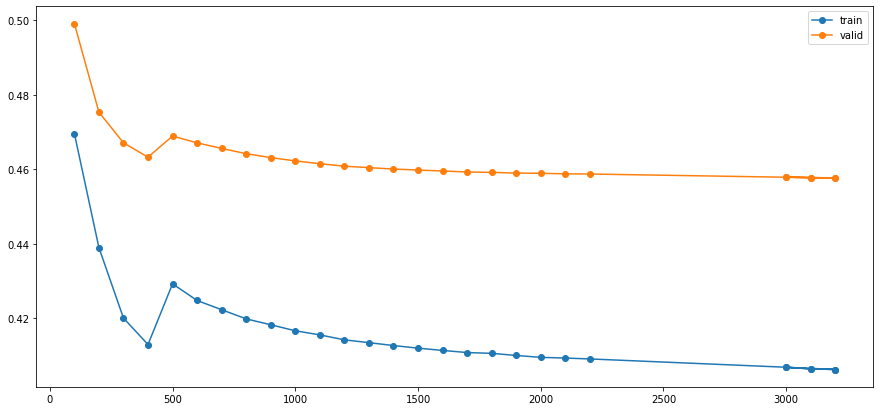

In [43]:
estimators_result = pd.concat([estimators_result, estimators_result_1, estimators_result_2])
plt.figure(figsize=(15,7))
plt.plot(estimators_result['n_estimators'], estimators_result['train_rmsle'], marker='o', label= 'train')
plt.plot(estimators_result['n_estimators'], estimators_result['valid_rmsle'], marker='o', label= 'valid')
plt.legend();

---

- We can see that rmsle on gets stable on `0.4590` after n_estimators 1800. So, we will keep the n_estimators value fixed to 1800 and next we will try to tune the max depth.


---

### `MAX_DEPTH`

- We will check the performance of the model on max_depth 2 to 9

---

In [44]:
# define max_depth 
def get_max_depth(evaluation_set, r_min, r_max):
    
    results = []
    
    for depth in range(r_min, r_max,1):
        SCORE_TRAIN = []
        SCORE_VALID = []
        x = {}
        for train, valid in (evaluation_set):
            # separate the independent and target variables 
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = valid['UNITS']

            # define the catboost model
            model = CatBoostRegressor(n_estimators=1800,
                                      random_seed=0,
                                      max_depth=depth,
                                      objective='RMSE',
                                      verbose=False,
                                      eval_metric='MSLE',
                                      cat_features=categorical_feature_indices)
            # fit the model with the training data
            model.fit(train_data_x, train_data_y,plot=False,eval_set=[(valid_data_x, valid_data_y)])
            
            # predict on train and valid 
            predict_train = model.predict(train_data_x).clip(min=0)
            predict_valid = model.predict(valid_data_x).clip(min=0)
            
            # get the rmsle on train and valid
            train_rmsle = get_msle(train_data_y, predict_train)
            valid_rmsle = get_msle(valid_data_y, predict_valid)
            
            SCORE_TRAIN.append(train_rmsle)
            SCORE_VALID.append(valid_rmsle)
            
        # calculate mean rmsle on train and valid    
        mean_rmsle_train = np.mean(SCORE_TRAIN)
        mean_rmsle_valid = np.mean(SCORE_VALID)
        
        x['max_depth'] = depth
        x['train_rmsle'] = mean_rmsle_train
        x['valid_rmsle'] = mean_rmsle_valid
        results.append(x)
        
        print('With Depth:\t'+ str(depth) + '\tMEAN RMSLE TRAIN:\t' + str(mean_rmsle_train)+ '\tMEAN RMSLE VALID: '+str(mean_rmsle_valid))
        

    return results       
    

In [45]:
# calculate the max_depth_results
max_depth_results= get_max_depth(evaluation_sets,r_min=2,r_max=10)

With Depth:	2	MEAN RMSLE TRAIN:	0.4445394641319095	MEAN RMSLE VALID: 0.4860494379585192
With Depth:	3	MEAN RMSLE TRAIN:	0.4282576148781311	MEAN RMSLE VALID: 0.4741547883647669
With Depth:	4	MEAN RMSLE TRAIN:	0.42560428660311256	MEAN RMSLE VALID: 0.4667204289033166
With Depth:	5	MEAN RMSLE TRAIN:	0.4180172455692529	MEAN RMSLE VALID: 0.46251526401623966
With Depth:	6	MEAN RMSLE TRAIN:	0.410606352071611	MEAN RMSLE VALID: 0.45913991301653245
With Depth:	7	MEAN RMSLE TRAIN:	0.4078343510227507	MEAN RMSLE VALID: 0.45782522277404697
With Depth:	8	MEAN RMSLE TRAIN:	0.4023340837969485	MEAN RMSLE VALID: 0.45764240156052927
With Depth:	9	MEAN RMSLE TRAIN:	0.3998941363141936	MEAN RMSLE VALID: 0.4594457607278959


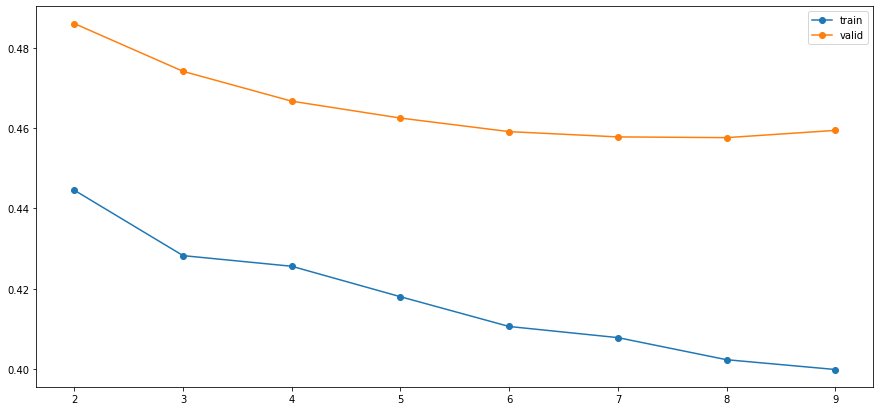

In [46]:
max_depth_results = pd.DataFrame.from_dict(max_depth_results)
plt.figure(figsize=(15,7))
plt.plot(max_depth_results['max_depth'], max_depth_results['train_rmsle'], marker='o', label= 'train')
plt.plot(max_depth_results['max_depth'], max_depth_results['valid_rmsle'], marker='o', label= 'valid')
plt.legend();

---

We can see that the best rmsle is 0.4576 on validation data with max_depth 8. So, we will fix this value and tune the model further to get the best value of the learning rate.


## `LEARNING RATE`
- We will try multiple values of the learning rate from 0 to 1 and choose the best one.

---

In [34]:
# define function to tune the learning rate.
def get_learning_rate(evaluation_set):
    
    results = []
    
    for lr in [0.001, 0.01, 0.05, 0.075, 0.1, 0.5, 1]:
        SCORE_TRAIN = []
        SCORE_VALID = []
        x = {}
        for train, valid in (evaluation_set):
            
            # separate the independent and target variables
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = valid['UNITS']

            # define the catboost model
            model = CatBoostRegressor(n_estimators=1800,
                                      random_seed=0,
                                      max_depth=8,
                                      learning_rate=lr,
                                      objective='RMSE',
                                      verbose=False,
                                      eval_metric='MSLE',
                                      cat_features=categorical_feature_indices)
            
            # fit the model with the training data
            model.fit(train_data_x, train_data_y,plot=False,eval_set=[(valid_data_x, valid_data_y)])
            
            # predict on the train and validation data
            predict_train = model.predict(train_data_x).clip(min=0)
            predict_valid = model.predict(valid_data_x).clip(min=0)
            
            # calculate the rmsle on train and valid
            train_rmsle = get_msle(train_data_y, predict_train)
            valid_rmsle = get_msle(valid_data_y, predict_valid)
            
            SCORE_TRAIN.append(train_rmsle)
            SCORE_VALID.append(valid_rmsle)
            
            
        # calculate the mean rmsle on train and validation    
        mean_rmsle_train = np.mean(SCORE_TRAIN)
        mean_rmsle_valid = np.mean(SCORE_VALID)
        x['learning_rate'] = lr
        x['train_rmsle'] = mean_rmsle_train
        x['valid_rmsle'] = mean_rmsle_valid
        results.append(x)
        
        print('With Learning Rate:\t'+ str(lr) + '\tMEAN RMSLE TRAIN:\t' + str(mean_rmsle_train)+ '\tMEAN RMSLE VALID: '+str(mean_rmsle_valid))
        

    return results       
    

In [35]:
# learning_rate_results
learning_rate_results = get_learning_rate(evaluation_sets)

With Learning Rate:	0.001	MEAN RMSLE TRAIN:	0.4674673393182468	MEAN RMSLE VALID: 0.49906281093497784
With Learning Rate:	0.01	MEAN RMSLE TRAIN:	0.41693963032435083	MEAN RMSLE VALID: 0.4648789720987847
With Learning Rate:	0.05	MEAN RMSLE TRAIN:	0.39781672704597476	MEAN RMSLE VALID: 0.45511272122083374
With Learning Rate:	0.075	MEAN RMSLE TRAIN:	0.3932084354070599	MEAN RMSLE VALID: 0.4534900896687279
With Learning Rate:	0.1	MEAN RMSLE TRAIN:	0.39386922034000227	MEAN RMSLE VALID: 0.4543158220731307
With Learning Rate:	0.5	MEAN RMSLE TRAIN:	0.42344863497116153	MEAN RMSLE VALID: 0.49148792592187535
With Learning Rate:	1	MEAN RMSLE TRAIN:	0.514437894328865	MEAN RMSLE VALID: 0.5730291136298364


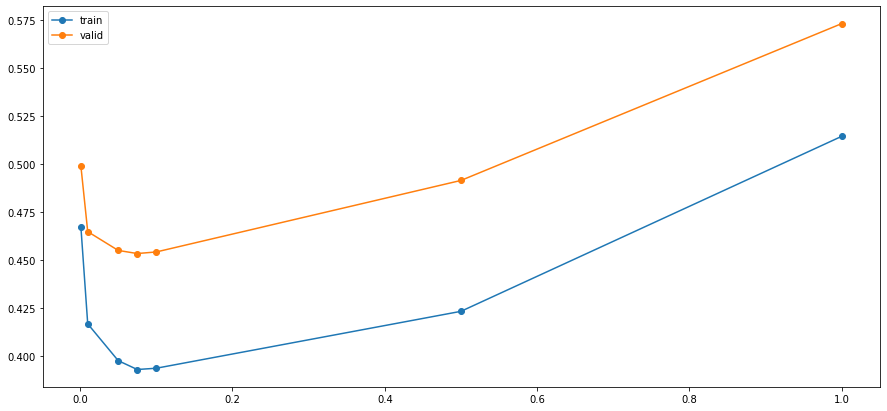

In [36]:
learning_rate_results = pd.DataFrame.from_dict(learning_rate_results)
plt.figure(figsize=(15,7))
plt.plot(learning_rate_results['learning_rate'], learning_rate_results['train_rmsle'], marker='o', label= 'train')
plt.plot(learning_rate_results['learning_rate'], learning_rate_results['valid_rmsle'], marker='o', label= 'valid')
plt.legend();

---

- The best performance of the model is `0.4534` with the learning rate 0.075. So we will keep this value fixed and tune the model to get the best value of l2 regularization.

## `L2_REG`

Any positive value is allowed for the parameter l2_reg so we will try the model performance on the some values between 1 to 100.

---

In [37]:
def get_l2_reg(evaluation_set):
    
    results = []
    
    for l2 in [1, 2, 3, 4, 5, 10, 100]:
        SCORE_TRAIN = []
        SCORE_VALID = []
        x = {}
        for train, valid in (evaluation_set):
            
            # separate the target and independent values
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = valid['UNITS']

            # define the catboost model
            model = CatBoostRegressor(n_estimators=1800,
                                      l2_leaf_reg=l2,
                                      max_depth=8,
                                      learning_rate=0.075,
                                      objective='RMSE',
                                      verbose=False,
                                      eval_metric='MSLE',
                                      cat_features=categorical_feature_indices)
            # fit the model with the training data
            model.fit(train_data_x, train_data_y,plot=False,eval_set=[(valid_data_x, valid_data_y)])
            
            # predict on train and validation 
            predict_train = model.predict(train_data_x).clip(min=0)
            predict_valid = model.predict(valid_data_x).clip(min=0)
            
            # calculate the rmsle on train and valid
            train_rmsle = get_msle(train_data_y, predict_train)
            valid_rmsle = get_msle(valid_data_y, predict_valid)
            
            SCORE_TRAIN.append(train_rmsle)
            SCORE_VALID.append(valid_rmsle)
            
            
        # calculate the mean rmsle on train and valid    
        mean_rmsle_train = np.mean(SCORE_TRAIN)
        mean_rmsle_valid = np.mean(SCORE_VALID)
        x['l2_reg'] = l2
        x['rmsle_train'] = mean_rmsle_train
        x['rmsle_valid'] = mean_rmsle_valid
        results.append(x)
        
        print('With l2_reg:\t'+ str(l2) + '\tMEAN RMSLE TRAIN:\t' + str(mean_rmsle_train)+ '\tMEAN RMSLE VALID: '+str(mean_rmsle_valid))
        

    return results       
    

In [38]:
l2_results = get_l2_reg(evaluation_sets)

With l2_reg:	1	MEAN RMSLE TRAIN:	0.3993587977169731	MEAN RMSLE VALID: 0.4560416276896771
With l2_reg:	2	MEAN RMSLE TRAIN:	0.3976018215956207	MEAN RMSLE VALID: 0.45647059244303845
With l2_reg:	3	MEAN RMSLE TRAIN:	0.3932084354070599	MEAN RMSLE VALID: 0.4534900896687279
With l2_reg:	4	MEAN RMSLE TRAIN:	0.39136920756781013	MEAN RMSLE VALID: 0.45410548328483513
With l2_reg:	5	MEAN RMSLE TRAIN:	0.3948624572459439	MEAN RMSLE VALID: 0.4559821759358206
With l2_reg:	10	MEAN RMSLE TRAIN:	0.39321110912611656	MEAN RMSLE VALID: 0.4569206290002689
With l2_reg:	100	MEAN RMSLE TRAIN:	0.3920970715324771	MEAN RMSLE VALID: 0.45346506116154023


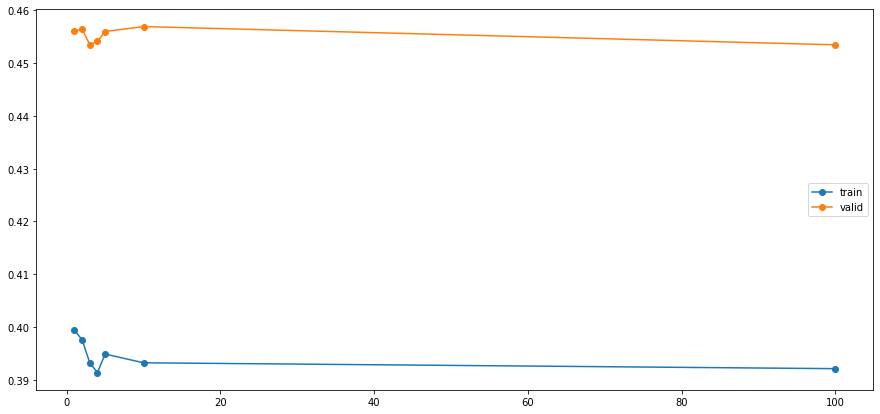

In [42]:
l2_results = pd.DataFrame.from_dict(l2_results)
plt.figure(figsize=(15,7))
plt.plot(l2_results['l2_reg'], l2_results['rmsle_train'], marker='o', label= 'train')
plt.plot(l2_results['l2_reg'], l2_results['rmsle_valid'], marker='o', label= 'valid')
plt.legend();

Here we can see that we are getting the best performance for L2_Reg value 3.

---

### `Final Hyperparameters for CatBoost`

The best performance is `0.4534` with the l2_reg value 3. So, now we have the optimal values of the parameters of catboost.

- ***N_ESTIMATORS*** : 1800
- ***LEARNING RATE*** : 0.075
- ***MAX_DEPTH*** : 8
- ***L2_REG*** : 3


---

In [79]:
# save the data used for training the catboost
final_data.to_csv('catboost_data.csv',index=False)